# Actividad Integradora

### Daniel Emilio Fuentes Portaluppi - A01708302

# Descripción
¡Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

**Puntos a considerar**
* La semilla para generación de números aleatorios será 67890.
* El almacén es 20x20 celdas.
* Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
* Todos los robots empiezan en posiciones aleatorias vacías. * Y, sólo puede haber un robot por celda.
* La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

**¿Que debes entregar?**
* Un cuaderno de Jupyter Notebook conteniendo un reporte de la actividad. El cuaderno deberá contener:
* Código fuente documentado.
* Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
* Una visualización que permita ver los diferentes pasos de la simulación.
* El número de pasos necesarios para terminar la simulación.
* ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

**Criterios de evaluación**
<br>Los criterios que se utilizarán para evaluar sus soluciones y seleccionar a los tres primeros ganadores son los siguientes:
* Aplicación original, innovadora y efectiva de algoritmos computacionales para resolver problemas específicos.
* El rendimiento de la implementación. El rendimiento de la implementación se medirá en función los pasos necesarios para terminar la simulación.
* La calidad de la descripción de análisis, diseño e implementación del sistema multiagente, la elegancia de su diseño e implementación.


In [89]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que todos los agentes inicien en una celda, elegimos ''MultiGrid''.
from mesa.space import SingleGrid, MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete 'seaborn' para hacer gráficas más atractivas.
import seaborn as sns

In [90]:
# Definimos la clase ''Organizer'' que hereda de ''Model''.
# Esta clase define el comportamiento de los agentes que van a organizar las cajas.
class Organizer(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.random.seed(67890)
        self.isCarrying = False
        self.attempts = 0
        self.max_attempts = 10
        self.minimal = 0

    # Definimos el método ''move'' que permite a los agentes moverse a una celda vacía.
    def random_move(self):
        possible_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )

        empty_cells = [
            cell for cell in possible_cells if self.model.grid.is_cell_empty(cell)
        ]

        if empty_cells:
            new_position = self.random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)

    # Definimos el método ''carry'' que permite a los agentes tomar una caja de una celda.
    def carry(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        for neighbor_pos in neighbors:
            x, y = neighbor_pos

            if self.model.piles < 39:
                if self.model.boxes[x, y] >= 1 and self.model.boxes[x, y] < 5 and self.isCarrying == False:
                    self.model.boxes[x, y] -= 1
                    self.isCarrying = True
                    self.minimal = self.model.boxes[x, y]
                    break
            else:
                if (self.model.boxes[x, y] == 1 or self.model.boxes[x, y] == 2) and self.isCarrying == False:
                    self.model.boxes[x, y] -= 1
                    self.isCarrying = True
                    break

    # Definimos el método ''drop'' que permite a los agentes dejar una caja en una celda.
    def drop(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        for neighbor_pos in neighbors:
            x, y = neighbor_pos
            if self.model.boxes[x, y] >= self.minimal and self.model.boxes[x, y] < 5 and self.isCarrying == True:
                self.model.boxes[x, y] += 1
                self.isCarrying = False
                return
        
    # Definimos el método ''step'' que permite a los agentes moverse, tomar y dejar cajas.
    def step(self):
        if not self.isCarrying:
            self.carry()
        else:
            self.drop()

        self.random_move()

In [91]:
# Definimos la función ''get_agents'' que nos permite obtener la posición de cada agente.
def get_agents(model):
    agents = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        x, y = agent.pos
        agents[x][y] = 1
    return agents

In [92]:
# Definimos la clase ''WareHouse'' que hereda de ''Model''.
# Esta clase define el entorno en el que se van a mover los agentes.
# además de definir el número de agentes que se van a crear y la 
# cantidad de cajas que se van a organizar.
class WareHouse(Model):
    def __init__(self, num_agents, width, height):
        self.random.seed(67890)
        self.grid = SingleGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height))
        self.schedule = SimultaneousActivation(self)
        self.piles = 0

        self.running = True

        reporters = {"Agents": get_agents, "Boxes": lambda m: self.boxes.copy()}

        self.datacollector = DataCollector(model_reporters=reporters)

        # Creamos los agentes en ubicaciones aleatorias.
        for i in range(num_agents):
            a = Organizer(i, self)
            self.schedule.add(a)
            
            # Intentar encontrar una celda vacía para el nuevo agente
            placed = False
            while not placed:
                x = self.random.randrange(width)
                y = self.random.randrange(height)
                if self.grid.is_cell_empty((x, y)):
                    self.grid.place_agent(a, (x, y))
                    placed = True

        # Creamos las cajas en ubicaciones aleatorias.
        num_boxes = 200
        for i in range(num_boxes):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            while self.boxes[x][y] >= 3:
                x = self.random.randrange(width)
                y = self.random.randrange(height)
            # Agregar una caja a la celda
            self.boxes[x][y] += 1

    # Definimos el método ''count_piles'' que permite contar el número de pilas de 5 cajas.
    def count_piles(self):
        temp_piles = 0
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                if self.boxes[x][y] == 5:
                    temp_piles += 1
        return temp_piles   

    # Definimos el método ''step'' que va a guardar la información de cada paso de la simulación.
    # Además, este método va a detener la simulación cuando se hayan organizado 40 pilas de 5 cajas.
    def step(self):
        self.count_piles()
        self.piles = self.count_piles()
        self.datacollector.collect(self)
        self.schedule.step()

        if self.piles == 40:
            self.running = False
    

In [93]:
# Definimos los parámetros que se van a usar para la simulación.
WIDTH = 20
HEIGHT = 20
N = 5

In [94]:
# Creamos una instancia de la clase ''WareHouse'', y ejecutamos la simulación.
model = WareHouse(N, WIDTH, HEIGHT)
while model.running:
    model.step()

# Obtenemos la información de cada paso de la simulación.
all_grid = model.datacollector.get_model_vars_dataframe()

In [95]:
# Print total steps
print("Tomó", model.schedule.steps, "pasos organizar", model.piles, "pilas de 5 cajas.")

Tomó 4509 pasos organizar 40 pilas de 5 cajas.


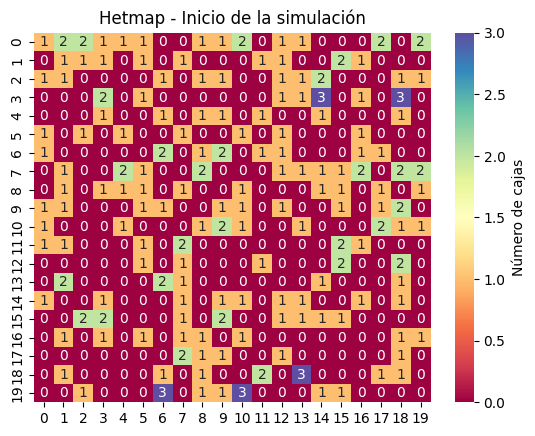

In [96]:
# Heatmap de la distribución de las cajas al inicio de la simulación.
all_grid = model.datacollector.get_model_vars_dataframe()
heatmap_data = all_grid["Boxes"].iloc[0] 

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="g",
    cmap="Spectral",
    cbar_kws={"label": "Número de cajas"},
)
plt.title("Hetmap - Inicio de la simulación")
plt.show()

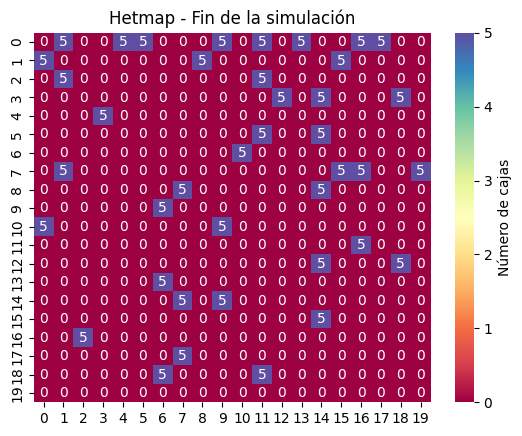

In [97]:
# Heatmap de la distribución de las cajas al final de la simulación
all_grid = model.datacollector.get_model_vars_dataframe()
heatmap_data = all_grid["Boxes"].iloc[model.schedule.steps - 1] 

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="g",
    cmap="Spectral",
    cbar_kws={"label": "Número de cajas"},
)
plt.title("Hetmap - Fin de la simulación")
plt.show()

In [98]:
# fig, axs = plt.subplots(figsize=(5,5))

# axs.set_xticks([])
# axs.set_yticks([])

# agents = all_grid.get('Agents')
# boxes = all_grid.get('Boxes')

# data = boxes + (4 * agents)

# patch = axs.imshow(data[0], cmap='Grays')
# plt.close()

# def animate(i):
#     patch.set_data(data[i])

# anim = animation.FuncAnimation(fig, animate, frames=model.schedule.steps, interval=100)

# anim

In [99]:
# Grafica del número de pilas por paso de la simulación.
plt.figure(figsize=(10, 5))
plt.plot(all_grid.piles, linewidth=1, color="green", label="Pilas")
plt.xlabel("Paso")
plt.ylabel("Número de pilas")
plt.title("Pilas x paso")

# Líneas verticales para los pasos específicos.
plt.axvline(x=100, color='red', linestyle='--', label='Paso 100')
plt.axvline(x=1000, color='cyan', linestyle='--', label='Paso 1000')
plt.axvline(x=10000, color='magenta', linestyle='--', label='Paso 10000')
plt.axvline(x=100000, color='purple', linestyle='--', label='Paso 100000')
plt.axvline(x=model.schedule.steps, color='black', linestyle='--', label=f'Paso {model.schedule.steps} (Total)')

plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'piles'

<Figure size 1000x500 with 0 Axes>